<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels simulation mapping analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we take as input the maps created in the previous notebook and use it to simulate an s2 signal for bb0nu events. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100 bb0nu events. </p>
-  <p style="font-size: 17px; color: black;"> Mapping separated by sensors. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

<h1> __________________________ </h1>
<h2> Read files </h2>

-  <p style="font-size: 17px; color: black;"> <b> S2 table </b> </p>

In [2]:
path = '/home/investigator/mariandbt/python/data'
path = path + '/20231025_NEXT100_full_mapping'

filename = os.path.join(path, "s2_table.h5")

# with tb.open_file(filename) as file:
#     print(file)

In [3]:
import h5py

# Load the 3D dictionary from the HDF5 file
loaded_data_dict = {}

columns = {0:'bin_initial_x',
           1:'bin_final_x',
           2:'bin_initial_y',
           3:'bin_final_y',
           4:'s2'
          }

with h5py.File(filename, 'r') as file:
    for table_id in file.keys():
        # Get the column names from the HDF5 attributes
        loaded_data_dict[table_id] = pd.DataFrame(file[table_id][:])
        loaded_data_dict[table_id].rename(columns = columns, inplace=True)



In [4]:
s2_table = loaded_data_dict.copy()

In [5]:
# s2_table.keys()

-  <p style="font-size: 17px; color: black;"> <b> bb0nu </b> </p>

In [6]:
path = '/home/investigator/mariandbt/python/data'

path = path + '/20231025_NEXT100_full_mapping'

# filename = os.path.join(path, "Next100_bb.next.h5")
# bb_filename = os.path.join(path, "Next100_bb_100ev.next.h5")
# bb_filename = os.path.join(path, "next100_fibers/Next100_bb_10.next.h5") # 1K events
# bb_filename = os.path.join(path, "next100_fibers/20240111_Next100_bb_3.next.h5") # 200 events each (there's 1, 2 and 3)
bb_filename = os.path.join(path, "next100_fibers/20240122_Next100_bb_1.next.h5") # 1 full bb w s2


In [7]:
with tb.open_file(bb_filename) as file:
    print(file)

/home/investigator/mariandbt/python/data/20231025_NEXT100_full_mapping/next100_fibers/20240122_Next100_bb_1.next.h5 (File) ''
Last modif.: '2024-01-24T09:19:06+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(47,)) ''
/MC/hits (Table(786,)) ''
/MC/particles (Table(101386,)) ''
/MC/sns_positions (Table(3431,)) ''
/MC/sns_response (Table(2615102,)) ''



In [8]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
bb_data = pd.read_hdf(bb_filename, "/MC/sns_response")


bb_dst = bb_data.copy()


In [11]:
# we select the positions of the sensors at the end of the fibers
bb_sensors = pd.read_hdf(bb_filename, "/MC/sns_positions", where='sensor_name == F_SENSOR')

sens_fibers = bb_sensors.copy() # get the positions of said sensors


/home/investigator/miniconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/io/pytables.py:3523: IncompatibilityWarning: 
where criteria is being ignored as this version [0.0.0] is too old (or
not-defined), read the file in and write it out to a new file to upgrade (with
the copy_to method)

  warnings.warn(ws, IncompatibilityWarning)


In [10]:
# # we select the information of the ionization electrons only

# n_events = 100
# bb_ie_dict = {}

# chunksize = int(2e5)
# start = 0

# for ii, ev in enumerate(range(n_events)):
    
#     print(int(ii*100/n_events) + 1, ' %')
#     stop = start + chunksize

#     bb_particles = pd.read_hdf(bb_filename, "/MC/particles", 
#                                start = start, stop = stop, 
#                                low_memory=True)
    
#     bb_ie = bb_particles.groupby('event_id').get_group(ev).copy()
#     bb_ie = bb_ie.loc[bb_ie.particle_name == 'ie-']
    
#     if len(bb_ie) > 0:
#         bb_ie_dict[ev] = bb_ie

#     start = start + bb_particles.groupby('event_id').get_group(ev).index.max() - 1

In [11]:
# bb_ie_dict[0]

<h1> __________________________ </h1>
<h2> Global parameters </h2>

In [12]:
n_panels = 18
n_sensors = 90
dtheta = 2*np.pi/n_panels # rad

dpos = int(n_sensors/n_panels) # number of sensors in 1 panel


In [13]:
chunksize = int(2e5) # aprox length of an event to read the tables

In [14]:
# s2 map specs

s2_tab = s2_table[f'sens_200'] # all maps have the same specs, so we get whichever

x_nbins, y_nbins = len(s2_tab.bin_initial_x.unique()), len(s2_tab.bin_initial_y.unique())

x_bin_width = (s2_tab.bin_final_x - s2_tab.bin_initial_x)[0]
y_bin_width = (s2_tab.bin_final_y - s2_tab.bin_initial_y)[0]

x_min = s2_tab.bin_initial_x.min()
y_min = s2_tab.bin_initial_y.min()

x_max = s2_tab.bin_final_x.max()
y_max = s2_tab.bin_final_y.max()

fiducial_radio = x_max - 20 # [mm] fiducial cut of 2cm away from the panels


<h1> __________________________ </h1>
<h2> Functions </h2>



In [15]:
def sens_map(selected_id):
    
    # we select the response of the sensors at the end of the fibers
    pp = '/home/investigator/mariandbt/python/data'
    pp = pp + '/20231025_NEXT100_full_mapping'

    flnm = os.path.join(pp, "Next100_full_mapp_s2_inicioEL_100Kev.next.h5")
    sens = pd.read_hdf(flnm, "/MC/sns_positions")
    dst_particle = pd.read_hdf(flnm, "/MC/particles")

    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(11,11), constrained_layout=True)
    
    ax.plot(dst_particle.initial_x, dst_particle.initial_y, 'o')


    fiber_sens_mask = sens.loc[sens.sensor_name == 'F_SENSOR'].sensor_id # ID mask of the sensors at the end of the fibers

    sens_fibers = sens.loc[sens.sensor_id.isin(fiber_sens_mask)] # get the positions of said sensors

    font_size = 11
    ax.plot(sens_fibers.x, sens_fibers.y, 'o', markersize = 2*font_size)
    
    labels_fontsize = 2*font_size
    
    ax.set_xlabel('X-coordinate [mm]', fontsize = labels_fontsize)
    ax.set_ylabel('Y-coordinate [mm]', fontsize = labels_fontsize)
    ax.tick_params(axis='both', labelsize = labels_fontsize*2/3)

    for sens_id in sens_fibers.sensor_id:
        xx = float(sens_fibers.loc[sens_fibers.sensor_id == sens_id].x)
        yy = float(sens_fibers.loc[sens_fibers.sensor_id == sens_id].y)

        ax.annotate(f'{sens_id:.0f}', (xx, yy),
                    color='black', ha='center', va='center', fontsize = font_size)

    if selected_id in sens_fibers.sensor_id.values:
#         ax.plot(sens_fibers.loc[sens_fibers.sensor_id == selected_id].x, 
#                 sens_fibers.loc[sens_fibers.sensor_id == selected_id].y, 'om', 
#                 markersize = 2*font_size, label = 'Selected sensor')

        ax.legend(fontsize = labels_fontsize, loc = (.4, .6))

    else:
        ax.annotate('Not (valid) sensor ID selected', (0, 100),
                    color='black', ha='center', va='center', fontsize = font_size)
        

No handles with labels found to put in legend.


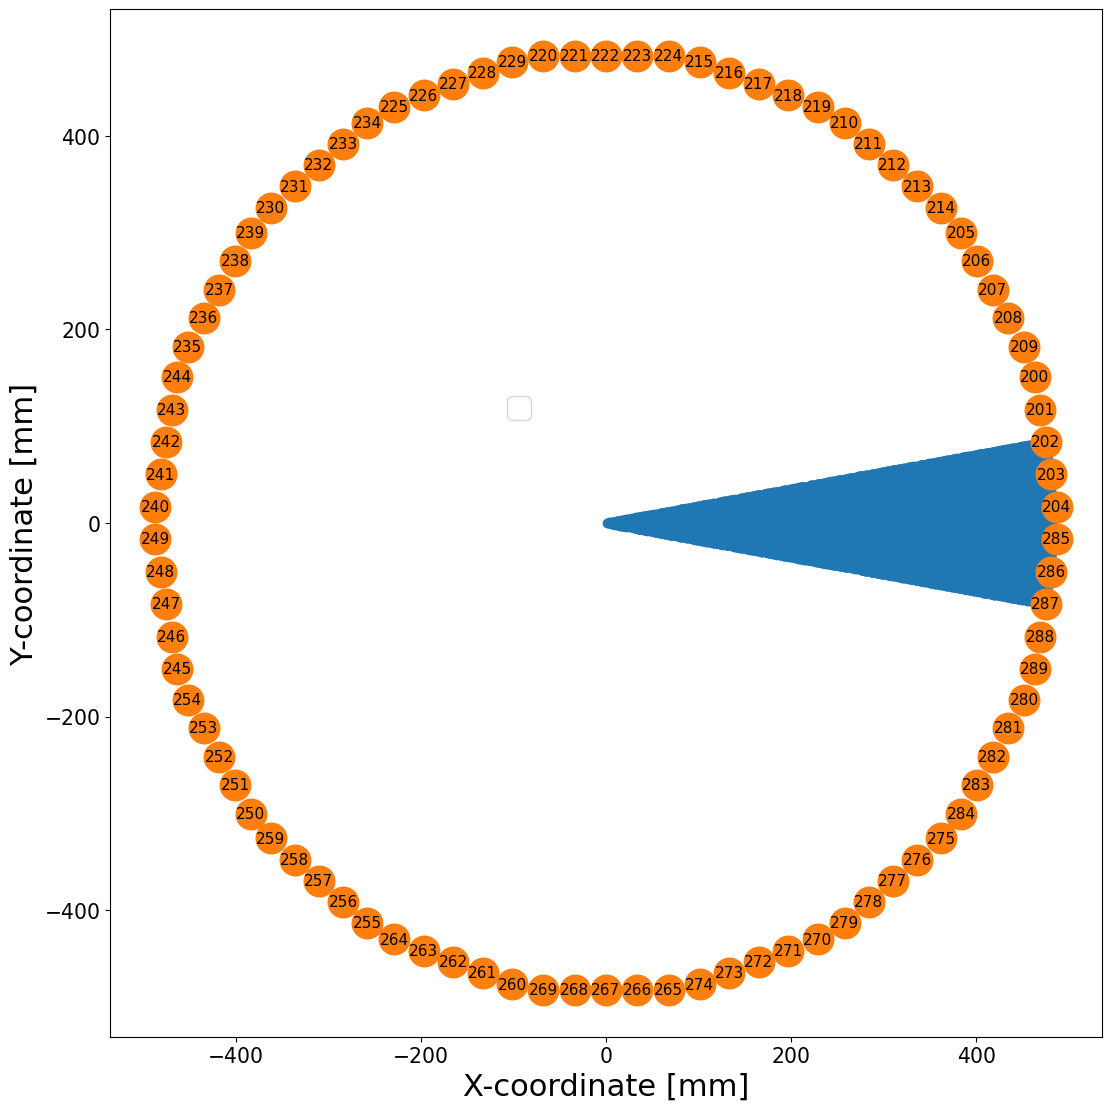

In [16]:
sens_map(203)


In [17]:
def find_rot(alpha):
    rot = -10

    while not ((alpha < (dtheta/2 + dtheta*rot)) & 
               (alpha > (-dtheta/2 + dtheta*rot))):
        rot += 1
        if rot > n_panels:
            print('ERROR')
            break

    return rot

# Vectorize the function
vect_find_rot = np.vectorize(find_rot)

In [18]:
def find_sensor(sensor_id, rot):
    
    theta = theta_dict[sensor_id]
    pos = theta_to_pos_dict[theta]

    new_pos = pos - rot*dpos
    
    if (new_pos == n_sensors/2):
        new_pos = -n_sensors/2
        
    if (new_pos > n_sensors/2):
        new_pos = new_pos%(n_sensors/2)
        
    if (new_pos < -n_sensors/2):
        new_pos = new_pos%(-n_sensors/2)
        
    new_theta = pos_to_theta_dict[new_pos]
    
    new_sens_id = sens_dict[new_theta]

    return new_sens_id


In [19]:
def find_s2(sens_id, part_id):
#     print(part_id)

    
    rr, alpha = rr_dict[part_id], alpha_dict[part_id]
    rot = rot_dict[part_id]
    new_xx, new_yy = new_xx_dict[part_id], new_yy_dict[part_id]

    new_sens_id = find_sensor(sens_id, rot) 
    s2_tab_matrix = s2_tab_dict[f'sens_{new_sens_id}']


    x_bin = int((new_xx - x_min)//x_bin_width)
    y_bin = int((new_yy - y_min)//y_bin_width)

    if ((new_xx > x_max) or 
        (new_yy > y_max) or
        (np.sqrt(new_xx**2 + new_yy**2) > fiducial_radio)
       ):
        s2_signal = 0.
    else:
        s2_signal = s2_tab_matrix[x_bin][y_bin]

#     if ((new_xx < x_max) & (new_yy < y_max)):
#         s2_signal = s2_tab_matrix[x_bin][y_bin]
#     else:
#         s2_signal = 0.

    return s2_signal

# Vectorize the function
vect_find_s2 = np.vectorize(find_s2)

In [20]:
def build_particle_dict(bb_ie):
    # particles
    tt_dict = dict(zip(bb_ie['particle_id'], bb_ie['final_t']))
    xx_dict = dict(zip(bb_ie['particle_id'], bb_ie['final_x']))
    yy_dict = dict(zip(bb_ie['particle_id'], bb_ie['final_y']))
    rr_dict = dict(zip(bb_ie['particle_id'], np.sqrt(bb_ie['final_x']**2 + bb_ie['final_y']**2)))
    alpha_dict = dict(zip(bb_ie['particle_id'], np.arctan2(bb_ie['final_y'], bb_ie['final_x'])))


    rr = np.array(list(rr_dict.values()))
    alpha = np.array(list(alpha_dict.values()))
    rotation = vect_find_rot(alpha)

    new_alpha = alpha - rotation * dtheta
    new_xx = rr * np.cos(new_alpha)
    new_yy = rr * np.sin(new_alpha)


    rot_dict = dict(zip(bb_ie['particle_id'], rotation))
    new_xx_dict = dict(zip(bb_ie['particle_id'], new_xx))
    new_yy_dict = dict(zip(bb_ie['particle_id'], new_yy))

    return tt_dict, xx_dict, yy_dict, rr_dict, alpha_dict, rot_dict, new_xx_dict, new_yy_dict

In [21]:
def find_bb_ie(bb_filename, start, event_id):
    
        stop = start + chunksize

        bb_particles = pd.read_hdf(bb_filename, "/MC/particles", 
                                   start = start, stop = stop, 
                                   low_memory=True)

        bb_ie = bb_particles.query(f'(event_id == {event_id}) & (particle_name == "ie-")')
        prim_e = bb_particles.query(f'(event_id == {event_id}) & (primary == 1)')
        
        new_start = start + bb_particles.query(f'(event_id == {event_id})').index.max() - 1 
        
        return new_start, bb_ie, prim_e

<h1> __________________________ </h1>
<h2> Dictionaries </h2>



In [22]:
# s2 table
s2_tab_dict = {}

for sens_id in s2_table.keys():

    s2_tab = s2_table[sens_id]
    s2_matrix = s2_tab.s2.to_numpy().reshape(x_nbins, y_nbins)
    
    s2_tab_dict[sens_id] = s2_matrix

In [23]:
# sensors
x_dict = dict(zip(sens_fibers['sensor_id'], sens_fibers['x']))
y_dict = dict(zip(sens_fibers['sensor_id'], sens_fibers['y']))

theta_sens = np.round(np.arctan2(sens_fibers['y'], sens_fibers['x']).tolist(), 3)

theta_dict = dict(zip(sens_fibers['sensor_id'], theta_sens)) # theta vs sensor_id
sens_dict = dict(zip(theta_sens, sens_fibers['sensor_id'])) # sensor_id vs theta

theta_to_pos_dict = dict(zip(sorted(theta_sens), np.arange(int(-n_sensors/2), 
                                                           int(n_sensors/2)))) # theta vs position_id
pos_to_theta_dict = dict(zip(np.arange(int(-n_sensors/2), int(n_sensors/2)), 
                             sorted(theta_sens))) # position_id vs theta


<h1> __________________________ </h1>


<h1> __________________________ </h1>


<h1> __________________________ </h1>


In [24]:
event_id = 0
start = 0
stop = start + chunksize

bb_particles = pd.read_hdf(bb_filename, "/MC/particles", 
                           start = start, stop = stop, 
                           low_memory=True).query(f'(event_id == {event_id})')
_, bb_ie, prim_e = find_bb_ie(bb_filename, start, event_id)


In [25]:
event_id = 0
start = 0

for event in range(event_id + 1):
# for event in [0, 1, 2]:
#     s2_ev_dict = {}

    stop = start + chunksize

    start, bb_ie, prim_e = find_bb_ie(bb_filename, start, event)

    

bb_particles = pd.read_hdf(bb_filename, "/MC/particles", 
                           start = stop - chunksize, stop = stop, 
                           low_memory=True).query(f'(event_id == {event_id})')

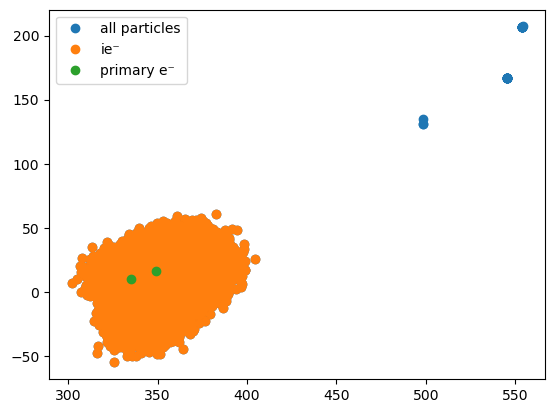

In [26]:
plt.plot(bb_particles.final_x, bb_particles.final_y, 'o', label = 'all particles')
plt.plot(bb_ie.final_x, bb_ie.final_y, 'o', label = 'ie⁻')
plt.plot(bb_particles.loc[bb_particles.primary == 1].final_x, 
         bb_particles.loc[bb_particles.primary == 1].final_y, 'o', label = 'primary e⁻')
plt.legend()
plt.show()

No handles with labels found to put in legend.


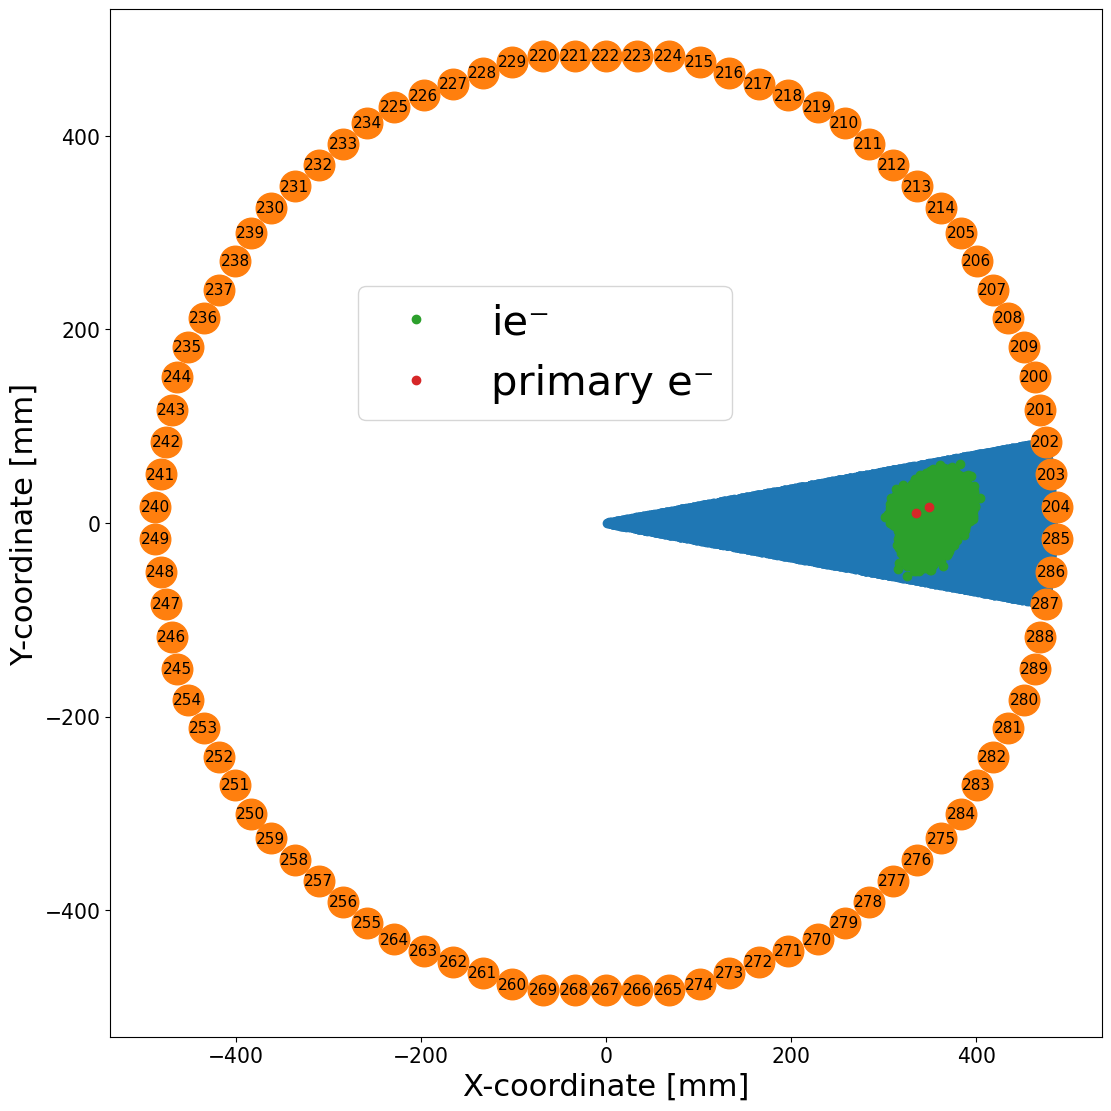

In [28]:
sens_map(203)
font_size = 15

plt.plot(bb_ie.final_x, bb_ie.final_y, 'o', label = 'ie⁻')
plt.plot(bb_particles.loc[bb_particles.primary == 1].final_x, 
         bb_particles.loc[bb_particles.primary == 1].final_y, 'o', label = 'primary e⁻')

plt.legend(fontsize = 2*font_size, loc = (0.25, 0.6))
plt.show()

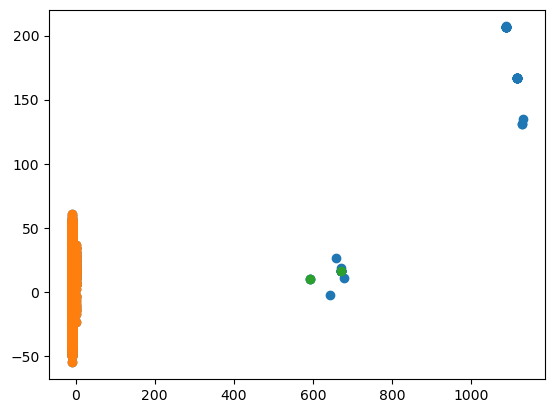

In [29]:
plt.plot(bb_particles.final_z, bb_particles.final_y, 'o')
plt.plot(bb_ie.final_z, bb_ie.final_y, 'o')
plt.plot(bb_particles.loc[bb_particles.primary == 1].final_z, 
         bb_particles.loc[bb_particles.primary == 1].final_y, 'o')
plt.show()

In [30]:
sens_id, part_id = 208, 1699

In [31]:
(tt_dict, xx_dict, yy_dict, 
 rr_dict, alpha_dict, 
 rot_dict, new_xx_dict, new_yy_dict) = build_particle_dict(bb_ie)

In [32]:
xx_dict

{199: 323.69293212890625,
 198: 343.1957092285156,
 197: 348.7157287597656,
 196: 351.2818298339844,
 195: 344.1643371582031,
 194: 329.224609375,
 193: 337.4524841308594,
 192: 329.41241455078125,
 191: 340.10699462890625,
 190: 328.1478576660156,
 189: 339.3447265625,
 188: 324.8579406738281,
 187: 332.92041015625,
 186: 346.9997863769531,
 185: 339.439453125,
 184: 334.0533142089844,
 183: 333.0227966308594,
 182: 331.5451965332031,
 181: 345.6436767578125,
 180: 335.61029052734375,
 179: 338.4136047363281,
 178: 335.2021179199219,
 177: 341.80975341796875,
 176: 320.4281311035156,
 175: 326.8088073730469,
 174: 335.8241882324219,
 173: 335.4029235839844,
 172: 329.0714416503906,
 171: 346.01092529296875,
 170: 341.1131286621094,
 169: 342.2618408203125,
 168: 336.6766357421875,
 167: 340.9608459472656,
 166: 338.5816955566406,
 165: 327.759033203125,
 164: 349.8863525390625,
 163: 340.51220703125,
 162: 326.8020324707031,
 161: 335.69970703125,
 160: 343.2005615234375,
 159: 328.24

In [33]:
filtered_dict = {key: value for key, value in yy_dict.items() if value > 70}

In [34]:
filtered_dict

{}

In [38]:
part_id = 199

No handles with labels found to put in legend.


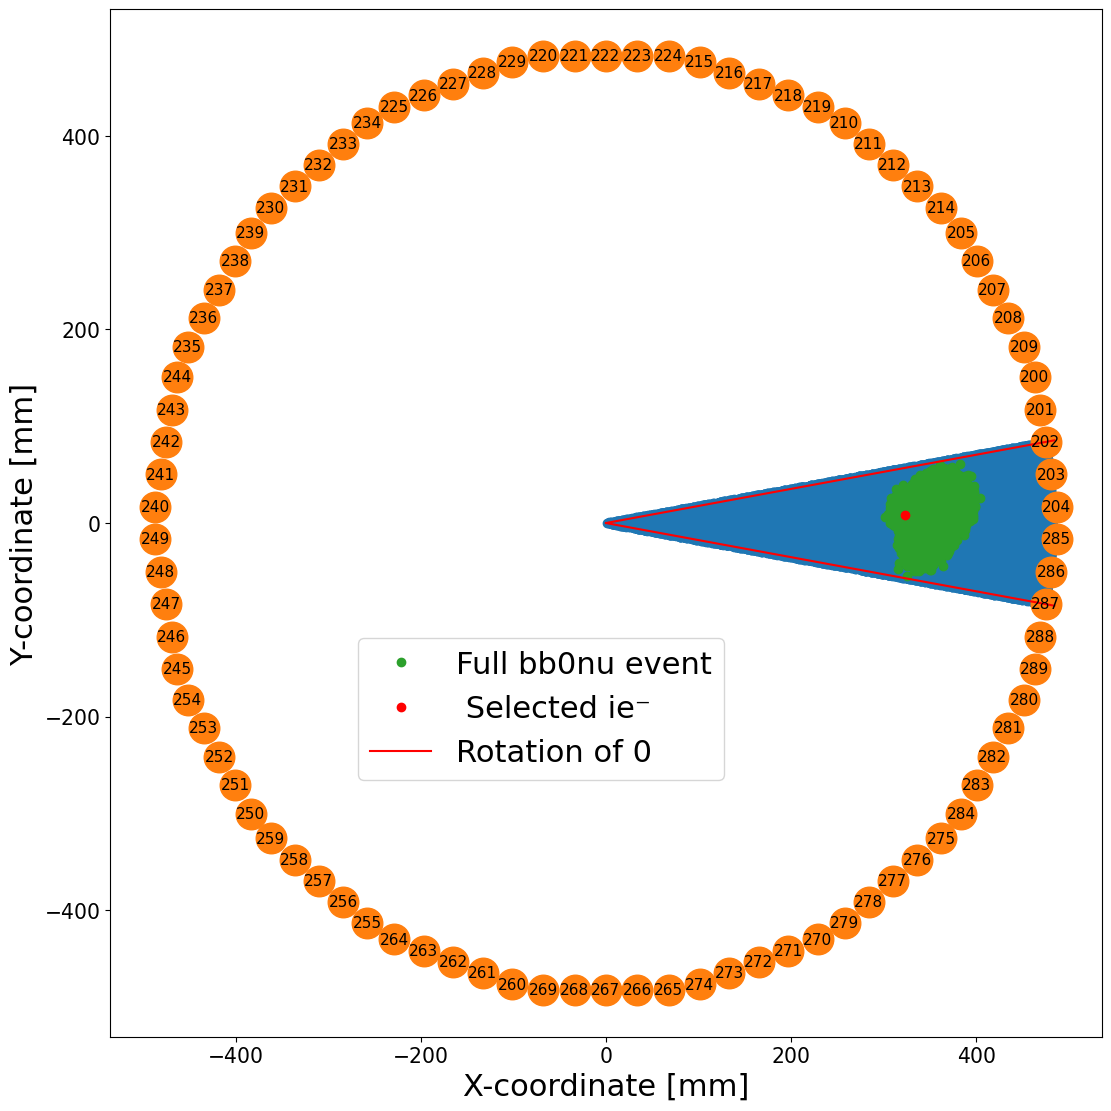

In [39]:
font_size = 11

xx = xx_dict[part_id]
yy = yy_dict[part_id]
alpha = np.arctan2(yy, xx)

sens_map(sens_id)
plt.plot(bb_ie.final_x, bb_ie.final_y, 'o', label = 'Full bb0nu event')

plt.plot(xx, yy, 'or', label = ' Selected ie⁻')

active_diam = 984 # [mm]
radius = np.linspace(0, active_diam/2, 100)
rot = find_rot(alpha)

xx_ = radius*np.cos(dtheta/2 + dtheta*(rot))
plt.plot(xx_ , xx_*np.tan(dtheta/2 + dtheta*(rot)), 'r')

xx_ = radius*np.cos(-dtheta/2 + dtheta*(rot))
plt.plot(xx_ , xx_*np.tan(-dtheta/2 + dtheta*(rot)), 'r', label = f'Rotation of {rot}')

plt.legend(fontsize = 2*font_size, loc = (0.25, 0.25))
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


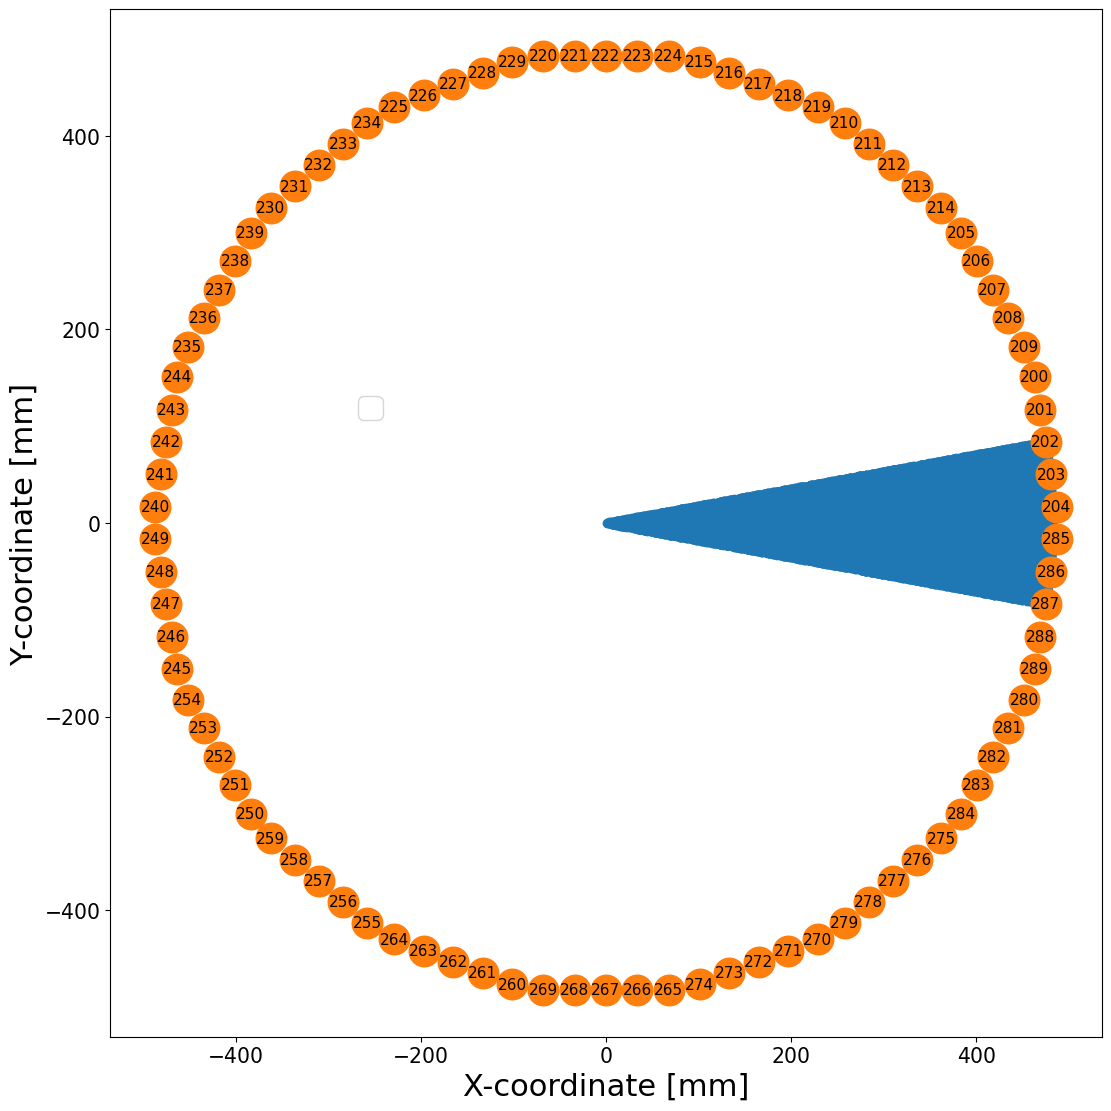

In [41]:
sens_map(203)
plt.legend(fontsize = 2*font_size, loc = (0.25, 0.6))

No handles with labels found to put in legend.


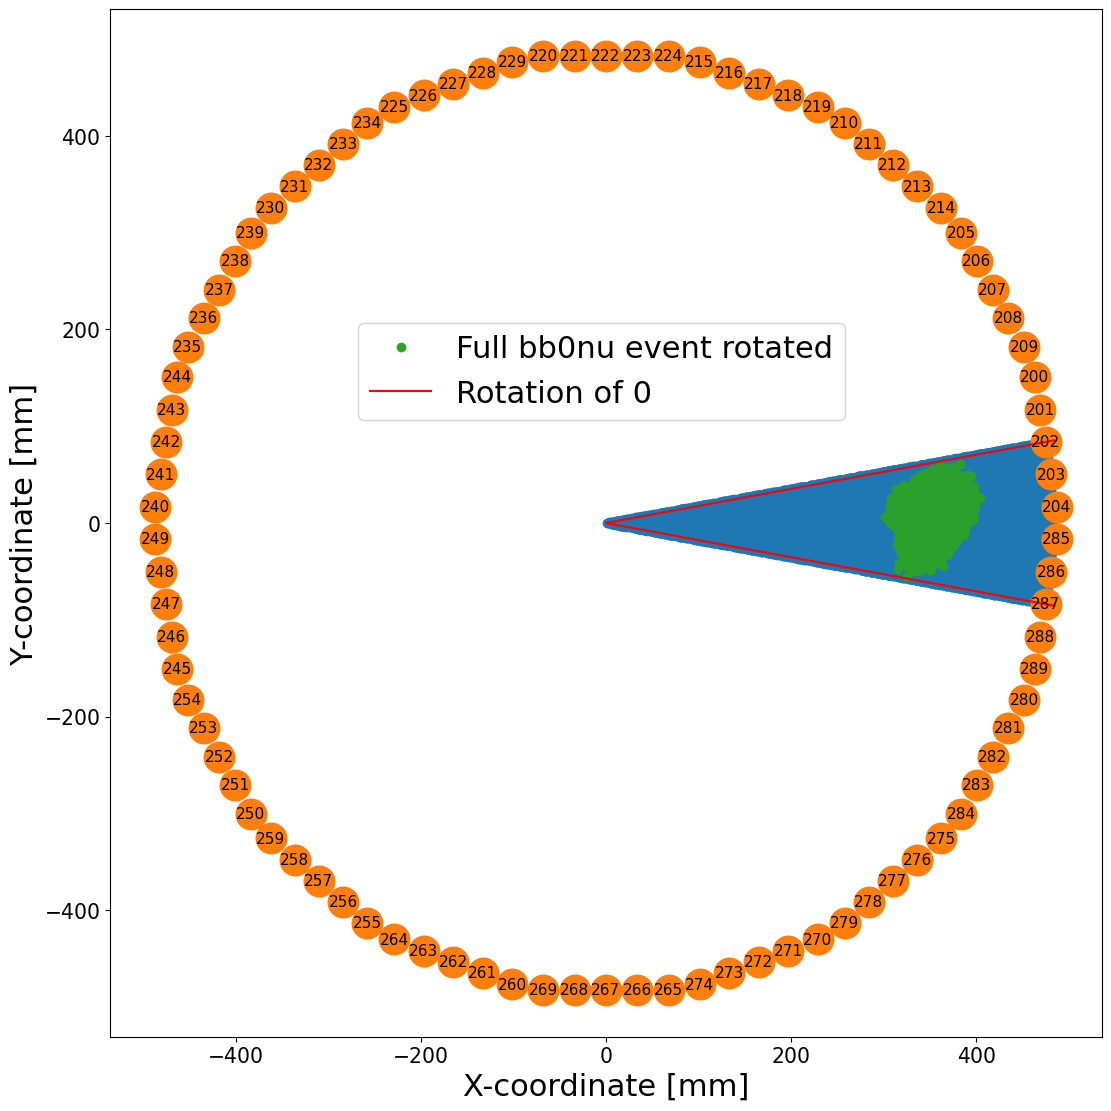

In [42]:
sens_map(203)

rr = np.array(list(rr_dict.values()))
alpha = np.array(list(alpha_dict.values()))

plt.plot(rr*np.cos(alpha - dtheta*(rot)), 
         rr*np.sin(alpha - dtheta*(rot)), 'o', label = 'Full bb0nu event rotated')

xx = rr_dict[part_id]*np.cos(alpha_dict[part_id] - dtheta*(rot))
yy = rr_dict[part_id]*np.sin(alpha_dict[part_id] - dtheta*(rot))

# plt.plot(xx, yy, 'or', label = ' Selected ie⁻ rotated')

xx_ = radius*np.cos(dtheta/2 + dtheta*(0))
plt.plot(xx_ , xx_*np.tan(dtheta/2 + dtheta*(0)), 'r')

xx_ = radius*np.cos(-dtheta/2 + dtheta*(0))
plt.plot(xx_ , xx_*np.tan(-dtheta/2 + dtheta*(0)), 'r', label = f'Rotation of {0}')

plt.legend(fontsize = 2*font_size, loc = (0.25, 0.6))
plt.show()

In [44]:
# %%timeit

# Specify the filename for the HDF5 file
filename = '../data/20231025_NEXT100_full_mapping/20240122_bb0nu_1fullev_s2_signal.h5'

# n_events = 200 # per file (3 files)
n_events = 1

chunksize = int(2e5)

# for ii, data_file in enumerate([1, 2, 3]):
for ii, data_file in enumerate([1]):
    
    # 200 events each (there's 1, 2 and 3)
#     bb_filename = os.path.join(path, f"next100_fibers/20240111_Next100_bb_{data_file}.next.h5") 
    bb_filename = os.path.join(path, "next100_fibers/20240122_Next100_bb_1.next.h5") # 1 full bb w s2
    start = 0

    # Open the HDF5 file in write mode
    with h5py.File(filename, 'w') as file:
        # s2_tot_dict = {}

    #     for event in bb_ie_dict.keys():
        for event in range(n_events):
        # for event in [0, 1, 2]:
        #     s2_ev_dict = {}

            start, bb_ie, prim_e = find_bb_ie(bb_filename, start, event)

            if len(bb_ie) > 0:

                group = file.create_group(str(n_events*ii + event))

        #         bb_ie = bb_ie_dict[event]

                (tt_dict, xx_dict, yy_dict, 
                 rr_dict, alpha_dict, 
                 rot_dict, new_xx_dict, new_yy_dict) = build_particle_dict(bb_ie)

                time_data = np.array(list(tt_dict.values()))

                for jj, sens_id in enumerate(sens_fibers.sensor_id[:]):

                    print(f'Sensor {jj}/{n_sensors} in event {event} of file {data_file}')
                    table_id = f'sens_{sens_id}'

                    s2_data = vect_find_s2(sens_id, bb_ie['particle_id'])


                    # Create the DataFrame after the loop using a dictionary
                    table_data = pd.DataFrame({'time': time_data, 's2': s2_data})
            #         s2_ev_dict[table_id] = table_data
                    group.create_dataset(table_id, data=table_data)

            #     s2_tot_dict[event] = s2_ev_dict


Sensor 0/90 in event 0 of file 1
Sensor 1/90 in event 0 of file 1
Sensor 2/90 in event 0 of file 1
Sensor 3/90 in event 0 of file 1
Sensor 4/90 in event 0 of file 1
Sensor 5/90 in event 0 of file 1
Sensor 6/90 in event 0 of file 1
Sensor 7/90 in event 0 of file 1
Sensor 8/90 in event 0 of file 1
Sensor 9/90 in event 0 of file 1
Sensor 10/90 in event 0 of file 1
Sensor 11/90 in event 0 of file 1
Sensor 12/90 in event 0 of file 1
Sensor 13/90 in event 0 of file 1
Sensor 14/90 in event 0 of file 1
Sensor 15/90 in event 0 of file 1
Sensor 16/90 in event 0 of file 1
Sensor 17/90 in event 0 of file 1
Sensor 18/90 in event 0 of file 1
Sensor 19/90 in event 0 of file 1
Sensor 20/90 in event 0 of file 1
Sensor 21/90 in event 0 of file 1
Sensor 22/90 in event 0 of file 1
Sensor 23/90 in event 0 of file 1
Sensor 24/90 in event 0 of file 1
Sensor 25/90 in event 0 of file 1
Sensor 26/90 in event 0 of file 1
Sensor 27/90 in event 0 of file 1
Sensor 28/90 in event 0 of file 1
Sensor 29/90 in event 0 